<img src='../img/joint_school_banner_2.png' alt='joint school banner' align='right' width='100%'></img>

<br>

# Measurements Of Pollution In The Troposphere (MOPITT) - Carbon Monoxide - Level 3 - Longterm time-series

### About

[MOPITT](https://www2.acom.ucar.edu/mopitt) is an instrument flying on NASA's Earth Observing System Terra spacecraft, measuring tropospheric carbon monoxide (CO) on the global scale. MOPITT measurements enable scientists to analyze the distribution, transport, sources and sinks of CO, a trace gas produced by methane oxidation, hydrocarbons released by plants, fossil fuel consumption and biomass burning. MOPITT has been operational since March 2000."

This notebook provides you an introduction to MOPITT Level 3 Carbon Monoxide data and lets you explore the longterm time series. The full name of this dataset is `MOPITT CO gridded monthly means (Thermal Infrared Radiances) V008`.

### Basic Facts

> **Spatial resolution**: `1° x 1°` <br>
> **Spatial coverage**: `60 degrees South to 60 degrees North` <br>
> **Processing level**:  `Level 3 Monthly averages` <br>
> **Data availability**: `since 2000`


### How to access the data

MOPITT Level 3 Carbon Monoxide data are disseminated in the `he5` format and can be downloaded via the [OPeNDAP portal](https://opendap.larc.nasa.gov/opendap/MOPITT/contents.html). The data used are in the folder with the name `MOP03T.008/`.

### Module outline
* [Load MOPITT CO Level 3 data from 2000 to 2022](#load_mopitt)
* [Create a data frame of zonal averages for southern and northern hemisphere aggregates](#dataframe)
* [Visualize the time-series of MOPITT CO from 2000 to 2022](#mopitt_visualize)

<hr>

#### Load required libraries

In [1]:
import os
import glob

import xarray as xr
import h5py
import numpy as np
import pandas as pd
import netCDF4
import datetime

# Python libraries for visualization
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
from matplotlib.axes import Axes

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
%run ../functions.ipynb

<hr>

## <a id='load_mopitt'></a>Load MOPITT CO Level 3 data from 2000 to 2022

Global MOPITT CO Level 3 data are available from 2000 to present. From this longterm time-series information, you can create a spatial average of a specific region and visualize the monthly MOPITT CO Level 3 content over time.

The MOPITT CO Level 3 are disseminated in the `he5` format. [h5py](https://docs.h5py.org/en/stable/), [xarray](https://xarray.pydata.org/en/stable/index.html) and [netCDF4](https://unidata.github.io/netcdf4-python/) are Python libraries you can use to access and manipulate datasets in `he5` format.

### Load HDF5 data with `netCDF4` and `xarray`

The aim is to create a `xarray.DataArray` that stores for each month the MOPITT CO data. The most efficient way is to do it in two steps: 
- (1) create a list of files
- (2) load one `HDF5` file using the Python library [h5py](https://www.h5py.org/) and load the relevant variables
- (3) create a `xarray.DataArray` object with the variables loaded
- (4) repeat the steps (2) and (3) for all monthly data files and create a multi-dimensional `xarray.DataArray` object
 

#### (1) Create a list of files

First step is to create a list with all the monthly CO files from MOPITT. You can create a list of files in Python with the library `glob`.

In [3]:
fileList = sorted(glob.glob('../../eodata/training_school/mopitt/v008/*.he5'))

#### (2) Load a `HDF5` file using the library h5py

You can load a `HDF5` file with the `File` constructor of the [h5py](https://www.h5py.org/) library. Load the file in `read` mode by setting the `mode` argument to `r`. The resulting object is a `HDF5 file` object, which acts like a Python dictionary. Thus, with the `keys` function you can list the different groups the file contains.

The relevant data are under the following group `HDFEO/GRIDS/MOP03/Data Fields/`:
* `RetrievedCOTotalColumnDay`
* `RetrievedCOTotalColumnNight`
* `Latitude`
* `Longitude`

In [4]:
file_name = fileList[0]
file = h5py.File(file_name, mode='r')

# load the data
dataset_day = file["/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOTotalColumnDay"][:]
dataset_night = file["/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOTotalColumnNight"][:]
lat = file["/HDFEOS/GRIDS/MOP03/Data Fields/Latitude"][:]
lon = file["/HDFEOS/GRIDS/MOP03/Data Fields/Longitude"][:]

dataset_day

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

#### (3) Create a xarray.DataArray object with the variables loaded

The next step is to build a multi-dimensional xarray.DataArray of the extracted arrays above. As you also want to add a time dimension to the data array, the first step is to extract the time information from the file name and store it as datetime object.

In [5]:
time = file_name.split('/')[6].split('-')[1]
time = datetime.datetime.strptime(time, '%Y%m')
time

datetime.datetime(2000, 3, 1, 0, 0)

For both data arrays, `dataset_day` and `dataset_night`, you can construct a xarray.DataArray with three dimensions: `time`, `lat` and `lon`. Once the xarray.DataArray is created, you want to filter out non-valid entries (-9999) with the xarray function `where()`.

In [6]:
# create xarray DataArray
co_day = xr.DataArray(dataset_day, 
                     dims=["lon","lat"], 
                     coords={
                         'time': pd.to_datetime(time),
                         'lon': lon,
                         'lat': lat},
                     attrs={
                         'long_name': 'CO Total Column - Day',
                         'units': 'molecules/cm2'})

co_day = co_day.where(co_day != -9999.)

co_night = xr.DataArray(dataset_night, 
                     dims=["lon","lat"], 
                     coords={
                         'time': pd.to_datetime(time),
                         'lon': lon,
                         'lat': lat},
                     attrs={
                         'long_name': 'CO Total Column - Night',
                         'units': 'molecules/cm2'})

co_night = co_night.where(co_night != -9999.)

The result is a two-dimension xarray.DataArray with coordinate information for time, latitude and longitude.

In [7]:
co_day

<xarray.DataArray (lon: 360, lat: 180)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     datetime64[ns] 2000-03-01
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:  CO Total Column - Day
    units:      molecules/cm2

#### (4) Loop over all data files and create a multi-dimensional xarray.DataArray object

In a next step, you now want to loop over all monthly MOPITT data files and repeat the same steps as above:
* Open the file with the `h5py` library
* Extract the relevant data under the `HDFEOS/GRIDS/MOP03/Data Fields/` group
* Retrieve the time information and save it as datetime object
* Construct two xarray.DataArrays for CO day and night measurements
* Concatenate the data arrays and create a multi-dimensional data array of the monthly CO aggregates

In [8]:
for i in range(1,len(fileList)):
    file_name = fileList[i]
    
    # Open the file with the h5py library
    file = h5py.File(file_name, mode='r')
    
    # Extract the relevant data under the HDFEOS/GRIDS/MOP03/Data Fields/ group
    dataset_day = file["/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOTotalColumnDay"][:]
    dataset_night = file["/HDFEOS/GRIDS/MOP03/Data Fields/RetrievedCOTotalColumnNight"][:]

    lat = file["/HDFEOS/GRIDS/MOP03/Data Fields/Latitude"][:]
    lon = file["/HDFEOS/GRIDS/MOP03/Data Fields/Longitude"][:]
    
    # Retrieve the time information and save it as datetime object
    time = file_name.split('/')[6].split('-')[1]
    time = datetime.datetime.strptime(time, '%Y%m')
    
    # Construct two xarray.DataArrays for CO day and night measurements
    tmp_day = xr.DataArray(dataset_day, 
                     dims=["lon","lat"], 
                     coords={
                         'time': time,
                         'lon': lon,
                         'lat': lat},
                     attrs={
                         'long_name': 'CO Total Column - Day',
                         'units': 'molecules/cm2'})
    
    tmp_day_masked = tmp_day.where(tmp_day != -9999.)
    
    tmp_night = xr.DataArray(dataset_night, 
                     dims=["lon","lat"], 
                     coords={
                         'time': time,
                         'lon': lon,
                         'lat': lat},
                     attrs={
                         'long_name': 'CO Total Column - Night',
                         'units': 'molecules/cm2'})
    
    tmp_night_masked = tmp_night.where(tmp_night != -9999.)
    
    # Concatenate the data arrays and create a multi-dimensional data array of the monthly CO aggregates
    co_day = xr.concat([co_day, tmp_day_masked], dim='time')
    co_night = xr.concat([co_night, tmp_night_masked], dim='time')

The resulting data arrays have 263 time entries (monthly CO values from March 2000 to May 2022.

In [9]:
co_day, co_night

(<xarray.DataArray (time: 263, lon: 360, lat: 180)>
 array([[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
 ...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],
 
        [[nan, nan, nan, ..., nan, nan, nan],
    

## <a id='dataframe'></a> Create a data frame of zonal averages for southern and northern hemisphere

In a next step, we want create a `pandas.dataframe` with the time-series information for zonal averages for the southern and northern hemisphere as well as the global mean. In order to do this, we first have to aggregate over latitude and longitude, which can be done with the xarray function `mean`. The result are six one dimensional xarray.DataArrays, holding the monthly CO values reflecting three aggregation levels: `global`, `southern hemisphere` and `northern hemisphere`.

In [10]:
co_global_day = co_day.mean(dim=['lat','lon'])
co_sh_day = co_day.where(co_day.lat < 0, drop=True).mean(dim=['lat','lon'])
co_nh_day = co_day.where(co_day.lat >= 0, drop=True).mean(dim=['lat', 'lon'])
co_global_day, co_sh_day, co_nh_day

co_global_night = co_night.mean(dim=['lat','lon'])
co_sh_night = co_night.where(co_night.lat < 0, drop=True).mean(dim=['lat','lon'])
co_nh_night = co_night.where(co_night.lat >= 0, drop=True).mean(dim=['lat', 'lon'])
co_global_night, co_sh_night, co_nh_night

(<xarray.DataArray (time: 263)>
 array([1.6806858e+18, 1.7188638e+18, 1.6890614e+18, 1.6325953e+18,
        1.4894604e+18, 1.5320818e+18, 1.6265892e+18, 1.6784424e+18,
        1.6689752e+18, 1.6879575e+18, 1.7031713e+18, 1.6610495e+18,
        1.6423174e+18, 1.6201452e+18, 1.5966419e+18, 1.5837368e+18,
        1.6313668e+18, 1.6411283e+18, 1.6285469e+18, 1.6446056e+18,
        1.6516663e+18, 1.6560514e+18, 1.7002691e+18, 1.6307179e+18,
        1.5515941e+18, 1.4814078e+18, 1.5019851e+18, 1.6049026e+18,
        1.7330215e+18, 1.8073866e+18, 1.7649300e+18, 1.7323978e+18,
        1.6850302e+18, 1.6849522e+18, 1.6811804e+18, 1.6767614e+18,
        1.6350123e+18, 1.5735919e+18, 1.5660288e+18, 1.6392083e+18,
        1.6983132e+18, 1.7070560e+18, 1.6667447e+18, 1.6800183e+18,
        1.6352862e+18, 1.6403420e+18, 1.6671359e+18, 1.6730868e+18,
        1.5492603e+18, 1.4682774e+18, 1.5105100e+18, 1.5600976e+18,
        1.6567812e+18, 1.7059889e+18, 1.6740803e+18, 1.6725651e+18,
        1.662478

<br>

With the help of the function `to_dataframe()`, you can convert a one-dimension xarray.DataArray into a pandas.DataFrame. Let us convert the six data arrays and build two dataframes, for the CO day and night measurements. Each dataframe consists of three columns, holding the CO values of the three aggregation levels.

In [11]:
co_df_day = co_global_day.to_dataframe(name='co_global')
co_df_day['co_sh'] = co_sh_day.to_dataframe(name='co_sh')
co_df_day['co_nh'] = co_nh_day.to_dataframe(name='co_nh')
co_df_day

co_df_night = co_global_night.to_dataframe(name='co_global')
co_df_night['co_sh'] = co_sh_night.to_dataframe(name='co_sh')
co_df_night['co_nh'] = co_nh_night.to_dataframe(name='co_nh')
co_df_night

co_global         co_sh         co_nh
time                                                
2000-03-01  1.680686e+18  1.131112e+18  2.159775e+18
2000-04-01  1.718864e+18  1.165656e+18  2.237174e+18
2000-05-01  1.689061e+18  1.259336e+18  2.156840e+18
2000-06-01  1.632595e+18  1.341452e+18  1.968393e+18
2000-07-01  1.489460e+18  1.299624e+18  1.688019e+18
...                  ...           ...           ...
2022-01-01  1.545163e+18  1.063798e+18  1.983015e+18
2022-02-01  1.552135e+18  1.049781e+18  2.028012e+18
2022-03-01  1.575237e+18  1.064829e+18  2.050482e+18
2022-04-01  1.555441e+18  1.067125e+18  2.021886e+18
2022-05-01  1.463572e+18  1.104857e+18  1.850549e+18

[263 rows x 3 columns]

## <a id='mopitt_visualize'></a> Visualize the time-series of MOPITT CO from 2000 to 2022

The last step is to visualize the two dataframes separately. Let us begin to visualize the Monthly CO Day time measurements. You can use the function `plot.line()` to create a line plot out of a `pandas.DataFrame`.

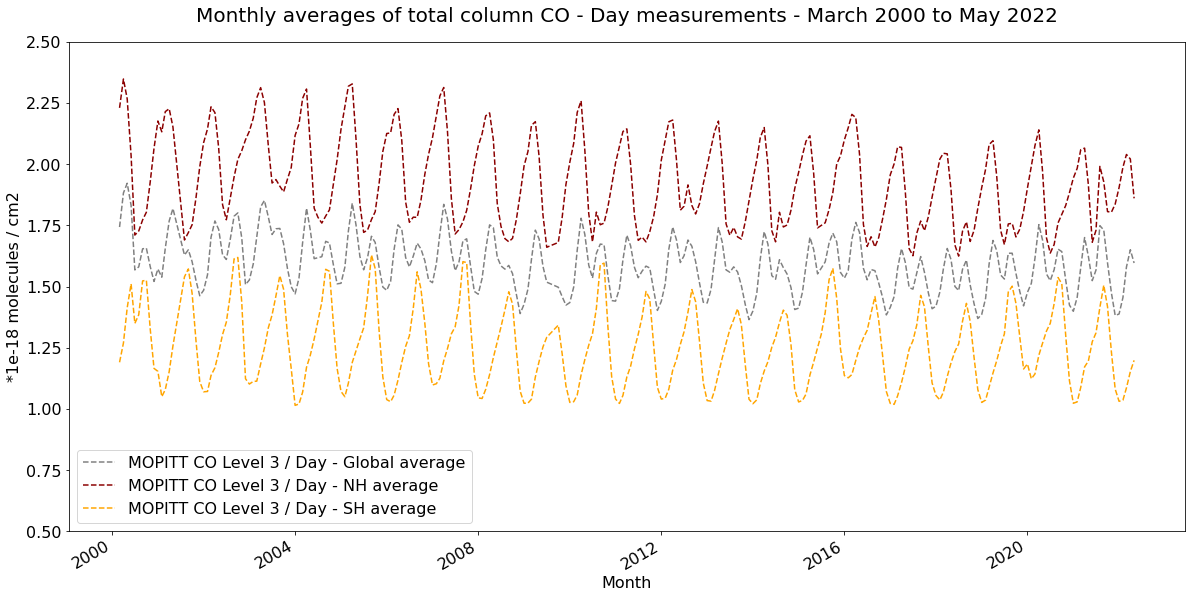

In [13]:
conversion_factor = 1e-18
fig, ax = plt.subplots(figsize=(20,10))

(co_df_day['co_global']*conversion_factor).plot.line(
    linestyle='dashed',
    color='grey', 
    label='MOPITT CO Level 3 / Day - Global average')

(co_df_day['co_nh']*conversion_factor).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='MOPITT CO Level 3 / Day - NH average')

(co_df_day['co_sh']*conversion_factor).plot.line(
    linestyle='dashed',
    color='orange',
    label='MOPITT CO Level 3 / Day - SH average')

ax.set_ylim(0.5,2.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title("Monthly averages of total column CO - Day measurements - March 2000 to May 2022", fontsize=20, pad=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('*1e-18 molecules / cm2', fontsize=16)

plt.legend(fontsize=16,loc=0)
plt.show()

Let us now repeat the same plot, but this time let us visualize the monthly CO nighttime measurements.

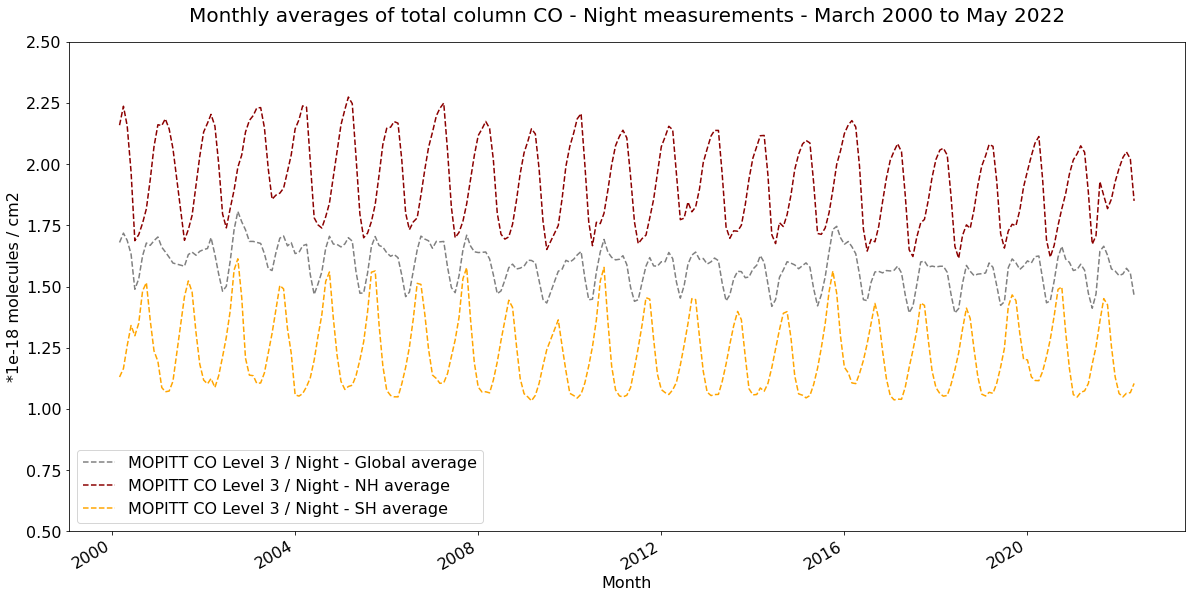

In [14]:
conversion_factor = 1e-18
fig, ax = plt.subplots(figsize=(20,10))

(co_df_night['co_global']*conversion_factor).plot.line(
    linestyle='dashed',
    color='grey', 
    label='MOPITT CO Level 3 / Night - Global average')

(co_df_night['co_nh']*conversion_factor).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='MOPITT CO Level 3 / Night - NH average')

(co_df_night['co_sh']*conversion_factor).plot.line(
    linestyle='dashed',
    color='orange',
    label='MOPITT CO Level 3 / Night - SH average')

ax.set_ylim(0.5,2.5)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.title("Monthly averages of total column CO - Night measurements - March 2000 to May 2022", fontsize=20, pad=20)
plt.xlabel('Month', fontsize=16)
plt.ylabel('*1e-18 molecules / cm2', fontsize=16)
plt.legend(fontsize=16,loc=0)
plt.show()

<hr>

<p><img src='../img/copernicus_logo.png' align='left' alt='Logo EU Copernicus' width='25%'></img></p>
<br clear=left>
<p style="text-align:left;">This project is licensed under the <a href="../LICENSE">MIT License</a>.</p>